In [1]:
import copy

import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam

import numpy as np

import gym
from gym.spaces import Discrete, Box

# log_prob tests

In [27]:
m = Categorical(logits=torch.tensor([ 0.3, 0.2, 0.25, 0.25 ]))

In [43]:
action_logits = torch.rand(5)
action_logits

tensor([0.9906, 0.7064, 0.6948, 0.1903, 0.2622])

In [46]:
action_probs = torch.nn.functional.softmax(action_logits, dim=-1)
action_probs

tensor([0.2917, 0.2195, 0.2170, 0.1310, 0.1408])

In [47]:
dist = Categorical(action_probs)

In [49]:
action = dist.sample()
action

tensor(2)

In [51]:
dist.log_prob(action)

tensor(-1.5279)

In [52]:
torch.log(action_probs[action])

tensor(-1.5279)

# REINFORCE Simplified Implementation

In [2]:
def mlp(sizes, activation=nn.Tanh, output_activation=nn.Identity):
    # Build a feedforward neural network.
    layers = []
    for j in range(len(sizes)-1):
        act = activation if j < len(sizes)-2 else output_activation
        layers += [nn.Linear(sizes[j], sizes[j+1]), act()]
    return nn.Sequential(*layers)

In [55]:
def reward_to_go(rews):
    n = len(rews)
    rtgs = np.zeros_like(rews)
    for i in reversed(range(n)):
        rtgs[i] = rews[i] + (rtgs[i+1] if i+1 < n else 0)
    return rtgs

In [61]:
def train(env_name='CartPole-v0', hidden_sizes=[32], lr=1e-2, epochs=50, batch_size=5000, render=False):
    # make environment, check spaces, get obs / act dims
    env = gym.make(env_name)
    assert isinstance(env.observation_space, Box), \
        "This example only works for envs with continuous state spaces."
    assert isinstance(env.action_space, Discrete), \
        "This example only works for envs with discrete action spaces."

    obs_dim = env.observation_space.shape[0]
    n_acts = env.action_space.n

    # make core of policy network
    logits_net = mlp(sizes=[obs_dim]+hidden_sizes+[n_acts])

    # make function to compute action distribution
    def get_policy(obs):
        logits = logits_net(obs)
        return Categorical(logits=logits)

    # make action selection function (outputs int actions, sampled from policy)
    def get_action(obs):
        return get_policy(obs).sample().item()

    # make loss function whose gradient, for the right data, is policy gradient
    def compute_loss(obs, act, weights):
        logp = get_policy(obs).log_prob(act)
        return -(logp * weights).mean()

    # make optimizer
    optimizer = Adam(logits_net.parameters(), lr=lr)

    # for training policy
    def train_one_epoch():
        # make some empty lists for logging.
        batch_obs = []          # for observations
        batch_acts = []         # for actions
        batch_weights = []      # for R(tau) weighting in policy gradient
        batch_rets = []         # for measuring episode returns
        batch_lens = []         # for measuring episode lengths

        # reset episode-specific variables
        obs = env.reset()[0]       # first obs comes from starting distribution
        done = False            # signal from environment that episode is over
        ep_rews = []            # list for rewards accrued throughout ep

        # render first episode of each epoch
        finished_rendering_this_epoch = False

        # collect experience by acting in the environment with current policy
        while True:
            # rendering
            if (not finished_rendering_this_epoch) and render:
                env.render()

            # save obs
            batch_obs.append(copy.deepcopy(obs))

            # act in the environment
            act = get_action(torch.as_tensor(obs, dtype=torch.float32))
            obs, rew, done, truncated, info = env.step(act)
            
            # save action, reward
            batch_acts.append(act)
            ep_rews.append(rew)
 
            if done:
                # if episode is over, record info about episode
                ep_ret, ep_len = sum(ep_rews), len(ep_rews)
                batch_rets.append(ep_ret)
                batch_lens.append(ep_len)
                # print(ep_rews)

                # the weight for each logprob(a|s) is R(tau)
                # batch_weights += [ep_ret] * ep_len
                batch_weights += list(reward_to_go(ep_rews))

                # reset episode-specific variables
                obs, done, ep_rews = env.reset()[0], False, []

                # won't render again this epoch
                finished_rendering_this_epoch = True

                # end experience loop if we have enough of it
                if len(batch_obs) > batch_size:
                    break

        # take a single policy gradient update step
        optimizer.zero_grad()
        batch_loss = compute_loss(obs=torch.as_tensor(batch_obs, dtype=torch.float32),
                                  act=torch.as_tensor(batch_acts, dtype=torch.int32),
                                  weights=torch.as_tensor(batch_weights, dtype=torch.float32)
                                  )
        batch_loss.backward()
        optimizer.step()
        return batch_loss, batch_rets, batch_lens

    # training loop
    for i in range(epochs):
        batch_loss, batch_rets, batch_lens = train_one_epoch()
        print('epoch: %3d \t loss: %.3f \t return: %.3f \t ep_len: %.3f'%
                (i+1, batch_loss, np.mean(batch_rets), np.mean(batch_lens)))

In [62]:
train()

epoch:   1 	 loss: 8.966 	 return: 19.909 	 ep_len: 19.909
epoch:   2 	 loss: 10.336 	 return: 22.181 	 ep_len: 22.181
epoch:   3 	 loss: 11.143 	 return: 24.179 	 ep_len: 24.179
epoch:   4 	 loss: 13.012 	 return: 27.582 	 ep_len: 27.582
epoch:   5 	 loss: 14.664 	 return: 30.736 	 ep_len: 30.736
epoch:   6 	 loss: 16.996 	 return: 36.664 	 ep_len: 36.664
epoch:   7 	 loss: 22.514 	 return: 47.245 	 ep_len: 47.245
epoch:   8 	 loss: 22.453 	 return: 47.933 	 ep_len: 47.933
epoch:   9 	 loss: 22.641 	 return: 55.659 	 ep_len: 55.659
epoch:  10 	 loss: 26.092 	 return: 56.444 	 ep_len: 56.444
epoch:  11 	 loss: 31.265 	 return: 67.182 	 ep_len: 67.182
epoch:  12 	 loss: 28.642 	 return: 68.986 	 ep_len: 68.986
epoch:  13 	 loss: 32.890 	 return: 79.873 	 ep_len: 79.873
epoch:  14 	 loss: 33.661 	 return: 80.619 	 ep_len: 80.619
epoch:  15 	 loss: 44.899 	 return: 119.143 	 ep_len: 119.143
epoch:  16 	 loss: 51.157 	 return: 133.395 	 ep_len: 133.395
epoch:  17 	 loss: 62.094 	 return: 1

# Spinningup Exercise 1_1

In [83]:
def soln_gaussian_likelihood(x, mu, log_std):
    EPS=1e-8
    
    pre_sum = -0.5 * (((x-mu)/(torch.exp(log_std)+EPS))**2 + 2*log_std + np.log(2*np.pi))
    return pre_sum.sum(axis=-1)

In [76]:
def gaussian_likelihood(x, mu, log_std):
    """
    Args:
        x: Tensor with shape [batch, dim]
        mu: Tensor with shape [batch, dim]
        log_std: Tensor with shape [batch, dim] or [dim]

    Returns:
        Tensor with shape [batch]
    """
    dim = x.shape[1]
    
    first_term = torch.sum(torch.square(x - mu) / torch.square(torch.exp(log_std)) + 2 * log_std, dim=-1)
    second_term = dim * torch.log(torch.as_tensor([torch.pi * 2]))
    
    return -0.5 * (first_term + second_term)

In [84]:
batch_size = 32
dim = 10

x = torch.rand(batch_size, dim)
mu = torch.rand(batch_size, dim)
log_std = torch.rand(dim)

your_gaussian_likelihood = gaussian_likelihood(x, mu, log_std)
true_gaussian_likelihood = soln_gaussian_likelihood(x, mu, log_std)

your_result = your_gaussian_likelihood.detach().numpy()
true_result = true_gaussian_likelihood.detach().numpy()

correct = np.allclose(your_result, true_result)

In [85]:
correct

True

# SARSA (Tabular)

In [167]:
import numpy as np
from tqdm import tqdm

In [196]:
class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,坐标轴原点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [197]:
class Sarsa:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
    
    def take_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_action)
        
        return np.argmax(self.Q_table[state])
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def update(self, s0, a0, r, s1, a1):
        td_err = r + self.gamma * self.Q_table[s1, a1] - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_err

In [198]:
ncol = 12
nrow = 4
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Sarsa(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

In [199]:
return_list = []

for i in range(num_episodes):
    state = env.reset()
    episode_return = 0
    done = False
    action = agent.take_action(state)
    
    while not done:
        next_state, reward, done = env.step(action)
        next_action = agent.take_action(next_state)
        episode_return += reward
        agent.update(state, action, reward, next_state, next_action)
        
        state = next_state
        action = next_action
    
    return_list.append(episode_return)

# Multi-step SARSA

In [216]:
class Nstep_Sarsa:
    def __init__(self, n, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
        self.n = n
        
        self.state_list = []
        self.action_list = []
        self.reward_list = []
    
    def take_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_action)
        
        return np.argmax(self.Q_table[state])
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def update(self, s0, a0, r, s1, a1, done):
        self.state_list.append(s0)
        self.action_list.append(a0)
        self.reward_list.append(r)
        
        if len(self.state_list) == self.n:
            G = self.Q_table[s1, a1]
            
            for i in reversed(range(self.n)):
                G = self.gamma * G + self.reward_list[i]
                
                if done and i > 0:
                    s = self.state_list[i]
                    a = self.action_list[i]
                    self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
            
            s = self.state_list.pop(0)
            a = self.action_list.pop(0)
            self.reward_list.pop(0)
            self.Q_table[s, a] += self.alpha * (G - self.Q_table[s, a])
        
        if done:
            self.state_list = []
            self.action_list = []
            self.reward_list = []

In [217]:
ncol = 12
nrow = 4
n_step = 5
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Nstep_Sarsa(n_step, ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

In [218]:
return_list = []

for i in range(num_episodes):
    state = env.reset()
    episode_return = 0
    done = False
    action = agent.take_action(state)
    
    while not done:
        next_state, reward, done = env.step(action)
        next_action = agent.take_action(next_state)
        episode_return += reward
        agent.update(state, action, reward, next_state, next_action, done)
        
        state = next_state
        action = next_action
    
    return_list.append(episode_return)

# Q-Learning

In [224]:
class Q_Learning:
    def __init__(self, ncol, nrow, epsilon, alpha, gamma, n_action=4):
        self.Q_table = np.zeros([nrow * ncol, n_action])  # 初始化Q(s,a)表格
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数
    
    def take_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.n_action)
        
        return np.argmax(self.Q_table[state])
    
    def best_action(self, state):
        Q_max = np.max(self.Q_table[state])
        a = [0 for _ in range(self.n_action)]
        for i in range(self.n_action):  # 若两个动作的价值一样,都会记录下来
            if self.Q_table[state, i] == Q_max:
                a[i] = 1
        return a
    
    def update(self, s0, a0, r, s1):
        td_err = r + self.gamma * np.max(self.Q_table[s1]) - self.Q_table[s0, a0]
        self.Q_table[s0, a0] += self.alpha * td_err

In [229]:
ncol = 12
nrow = 4
n_step = 5
env = CliffWalkingEnv(ncol, nrow)
np.random.seed(0)
epsilon = 0.1
alpha = 0.1
gamma = 0.9
agent = Q_Learning(ncol, nrow, epsilon, alpha, gamma)
num_episodes = 500  # 智能体在环境中运行的序列的数量

In [230]:
return_list = []

for i in range(num_episodes):
    state = env.reset()
    episode_return = 0
    done = False
    action = agent.take_action(state)
    
    while not done:
        next_state, reward, done = env.step(action)
        next_action = agent.take_action(next_state)
        episode_return += reward
        agent.update(state, action, reward, next_state)
        
        state = next_state
        action = next_action
    
    return_list.append(episode_return)

# DQN

In [1]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils

In [2]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [3]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [19]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones
                                                                )  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

In [50]:
lr = 2e-3
num_episodes = 500
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name)
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon, target_update, device)

In [56]:
return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()[0]
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, done, _, __ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

Iteration 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [01:44<00:00,  2.09s/it, episode=500, return=1118.800]


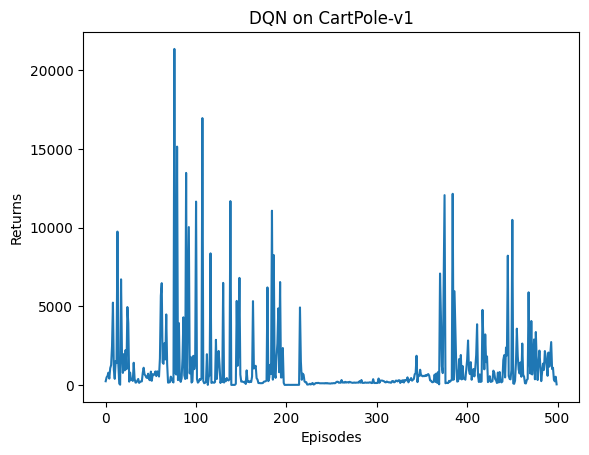

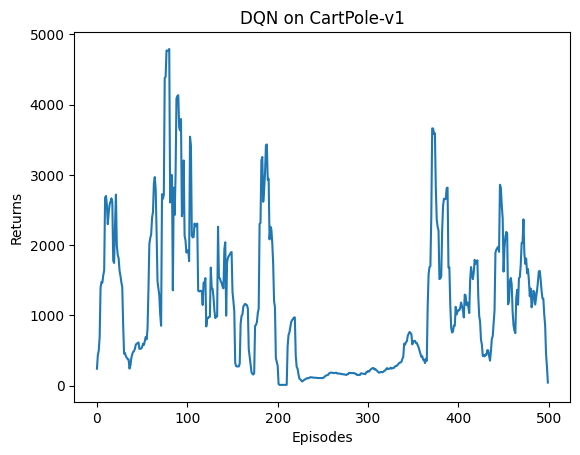

In [58]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

# Double DQN

In [64]:
class DQN:
    ''' DQN算法,包括Double DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim, self.action_dim).to(device)
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
        return action
    
    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        
        # 下个状态的最大Q值
        if self.dqn_type == 'DoubleDQN': # DQN与Double DQN的区别
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(1, max_action)
        else: # DQN的情况
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(-1, 1)
        
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        
        self.count += 1

In [84]:
lr = 1e-2
num_episodes = 200
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 50
buffer_size = 5000
minimal_size = 1000
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name, g=9.81)
state_dim = env.observation_space.shape[0]
action_dim = 11  # 将连续动作分成11个离散动作


def dis_to_con(discrete_action, env, action_dim):  # 离散动作转回连续的函数
    action_lowbound = env.action_space.low[0]  # 连续动作的最小值
    action_upbound = env.action_space.high[0]  # 连续动作的最大值
    return action_lowbound + (discrete_action / (action_dim - 1)) * (action_upbound - action_lowbound)

In [87]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,
              batch_size):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    episode_total_length = 200
    
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()[0]
                done = False
                episode_curr_length = 0
                
                while not done:
                    action = agent.take_action(state)
                    max_q_value = agent.max_q_value(state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    action_continuous = dis_to_con(action, env, agent.action_dim)
                    next_state, reward, done, _, __ = env.step([action_continuous])
                    replay_buffer.add(state, action, reward, next_state, done)
                    state = next_state
                    episode_return += reward
                    
                    if replay_buffer.size() > minimal_size:
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                    
                    episode_curr_length += 1
                    
                    if episode_curr_length >= episode_total_length:
                        break
                
                return_list.append(episode_return)
                
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':
                        '%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    
    return return_list, max_q_value_list

Iteration 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.01it/s, episode=200, return=-253.360]


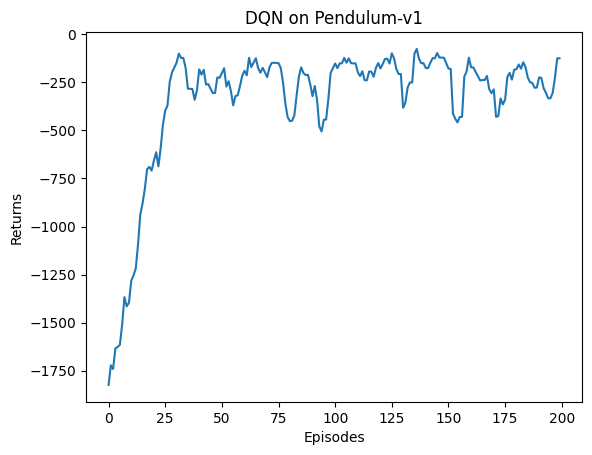

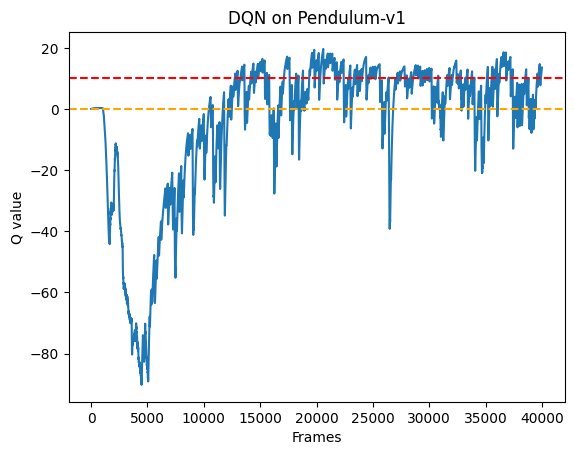

In [88]:
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('DQN on {}'.format(env_name))
plt.show()

Iteration 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.92it/s, episode=200, return=-152.709]


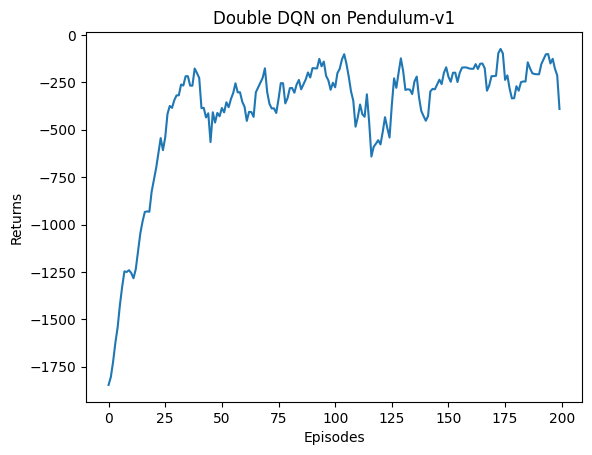

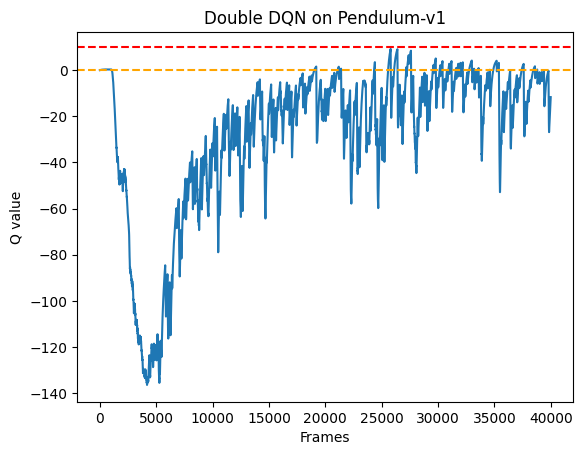

In [89]:
random.seed(0)
np.random.seed(0)
# env.seed(0)
torch.manual_seed(0)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device, 'DoubleDQN')
return_list, max_q_value_list = train_DQN(agent, env, num_episodes,
                                          replay_buffer, minimal_size,
                                          batch_size)

episodes_list = list(range(len(return_list)))
mv_return = rl_utils.moving_average(return_list, 5)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

frames_list = list(range(len(max_q_value_list)))
plt.plot(frames_list, max_q_value_list)
plt.axhline(0, c='orange', ls='--')
plt.axhline(10, c='red', ls='--')
plt.xlabel('Frames')
plt.ylabel('Q value')
plt.title('Double DQN on {}'.format(env_name))
plt.show()

# Dueling DQN